# A선박 전체 전처리 파이프라인 및 시각화 

In [1]:
import pandas as pd
# 데이터 row 값 생략 없이 모두 출력하기
#pd.set_option('display.max_rows', None)
# 초기화
pd.reset_option('display.max_rows')

In [2]:
import pandas as pd
import folium as f
import os
import glob
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import datetime
import random
import numpy as np
from haversine import haversine
from sklearn.cluster import DBSCAN
import itertools
from tqdm import tqdm

In [3]:
all_csv = glob('/STORAGE/DATA/01_KRISO_G_MAPPED_DATA/Position_LTEM/*.csv')
all_csv = sorted(all_csv)
selected_csv = all_csv[0:25]

total = pd.DataFrame()

for sel in tqdm(selected_csv):
    temp = pd.read_csv(sel, sep = ',', encoding='utf-8')
    total = pd.concat([total, temp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.21it/s]


In [4]:
total

,szMsgSendDT,SHIP_CODE,dSOG,dCOG,dLat,dLon
0,20220628110654000,BE010da2,6.331898,149.0,36.965206,126.828316
1,20220628110654000,AB110b5d,10.100000,272.0,37.874233,129.008636
2,20220628110654000,AB110b8e,0.000000,227.0,38.499546,128.425110
3,20220628110654000,AB0908a0,0.000000,0.0,34.556713,127.675613
4,20220628110654000,BD010d54,0.000000,275.0,35.978321,126.622986
...,...,...,...,...,...,...
738051,20220629115959000,AB02044d,9.479563,291.0,36.348801,129.429718
738052,20220629115959000,AB08064b,0.000000,333.0,36.249516,126.536850
738053,20220629115959000,BE020e3f,7.910589,173.0,35.364128,125.724831
738054,20220629115959000,AB010107,0.000000,256.0,36.675259,126.128418


In [5]:
# key 값은 A선박 종류 이름, value는 해당 dataframe을 받았다.

start_a_ship = total[total.SHIP_CODE.str.startswith('A')].SHIP_CODE.unique()

# key 값을 어선 종류, value 값을 해당 어선의 dataframe 으로 받게끔 했다.
dict_ = {}

for a_ship in start_a_ship:
    value  = total[total.SHIP_CODE.values == a_ship]
    dict_[a_ship] = value

# ---------------------------------

In [6]:
# SOG >= 2 Data frame 
def upper_2_dataframe(df):
    # Dict.values 안에 있는 dataframe -> list
    dict_to_lst = []
    
    for df in df.values():
        dict_to_lst.append(df[df.dSOG.values >=2])
    
    # SOG <2 제외 하고 데이터 프레임 갱신
    not_empty_df = [full for full in dict_to_lst if not full.empty]
    
    return not_empty_df

In [7]:
# 거리 파생변수 추가해주는 dataframe
def add_distance_df(df):
    
    for i in range(len(df)):
        dLat = df[i].dLat.tolist()
        dLon = df[i].dLon.tolist()
        position = []              # haversine 을 사용하기 위한 위, 경도 결합 리스트
        dist = []  # haversine 을 사용하여 직선거리를 담아 둘 리스트 (파생변수 담아 둘 리스트)
        
        for pos in zip(dLat, dLon):
            position.append(pos)

        for j in range(1, len(position)):
            dist.append(haversine(position[j-1], position[j]) * 1000) # haversine 은 default 가 km 이다.

        df[i]['dist'] = np.mean(dist)
        df[i]['dist'][1:] = dist
        
        position.clear()
        dist.clear()
    
    return df

In [8]:
# 이전 좌표와의 거리 10 이상 df
def dist_upper_10_df(df):
    for i in range(len(df)):
        df[i] = df[i][df[i].dist.values > 10]
    return df

In [9]:
# 시간을 보기좋게 전처리 (tooltip)
def reset_index_time_series(df):
    for i in range(len(df)):
        time_int = df[i].szMsgSendDT.values.tolist()
        time_str = []
        timestamp_ = []

        for j in range(len(time_int)):
            time_str.append(str(time_int[j]))
        # 시간 정보를 보기 좋게 바꿔준다
        for str_ in time_str:
            n = datetime.datetime.strptime(str_,"%Y%m%d%H%M%S%f")
            timestamp_.append(n.strftime("%Y-%m-%d-%H-%M-%S"))
        df[i]['szMsgSendDT'] = timestamp_
        
        time_str.clear()
        timestamp_.clear()

    return df

In [10]:
# COG 간격 컬럼 추가
def add_cog_interval(df):
    for i in range(len(df)):
        df[i]['dCOG_diff'] = abs(df[i]['dCOG'].diff())
    return df

In [11]:
'''
B선박
'''
upper_2 = upper_2_dataframe(dict_)
reset_time = reset_index_time_series(upper_2)

# 최종 전처리 셋 : 모든 A 선박, 하나의 DATAFRAME 으로 저장 
final_preprocessing  = pd.DataFrame()

for each_B_ship_df in reset_time:
    final_preprocessing = pd.concat([final_preprocessing, each_B_ship_df])
    
final_preprocessing.reset_index(inplace = True, drop = True)

import plotly.express as px
import plotly.offline as pyo

fig = px.line_mapbox(final_preprocessing, lat = "dLat", lon = "dLon", color = 'SHIP_CODE', zoom =3, height=900)

# 지도 배경 layout 토큰
fig.update_layout(mapbox=dict(
    accesstoken='pk.eyJ1IjoibGFnb29uNiIsImEiOiJjbGd4M2gycmkwM3VzM3JscGQ0YzlxYjU1In0.CBy01IB-Z8klhIcFRnkXKg',
    zoom=3
))
    
pyo.plot(fig, filename = 'B선박 전체동선(전처리 전).html')

'B선박 전체동선(전처리 전).html'

In [12]:
# 직선에 가장 가까운 상위 3가지 동선만 남기기
def similar_straight_cog(df):
    
    flag = True
    
    for i in range(len(df)):
        df[i] = df[i].reset_index()
        df[i].drop(labels = 'index', axis = 1, inplace = True)
        
        # 이전 좌표와 COG 간격 차이가 20이상이 되는 순간들의 index 좌표들만 추출
        index_lst = []
        for idx, col in df[i].iterrows():
            if col['dCOG_diff'] >= 20:
                index_lst.append(idx)
        
        # 직선에 가까운 상위 3가지 동선 (인덱스 차이) 추출
        interval_lst = []
        for j in range(1,len(index_lst)):
            interval_lst.append(index_lst[j] - index_lst[j-1])
        sorted_interval_lst = sorted(interval_lst, reverse = True)
        sort_3 = sorted_interval_lst[:3]


        final = []
        for k in range(1, len(index_lst)):
            if index_lst[k] - index_lst[k-1] in sort_3:
                final.append([index_lst[k-1], index_lst[k]])

        indexes_to_keep = []
        for start, end in final:
            indexes_to_keep.extend(list(range(start, end + 1)))
        
        # 두번째 데이터 프레임 부터는 리스트를 초기화 하지 않는다.
        if flag :
            filtered_df = []

        # 인덱스에 해당 행만 남기고 나머지 행 제거
        filtered_df.append(df[i].iloc[indexes_to_keep])
        flag = False
    
    return filtered_df

In [13]:
upper_2 = upper_2_dataframe(dict_)
add_dist = add_distance_df(upper_2)
dist_upper_10 = dist_upper_10_df(add_dist)
reset_time = reset_index_time_series(dist_upper_10)
add_cog = add_cog_interval(reset_time)
straigt_line = similar_straight_cog(add_cog)

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

/home/suresoft/anaconda3/envs/InternShelter/lib/python3.8/site-packages/numpy/core/fromn

In [14]:
# 최종 전처리 셋 : 모든 A 선박, 하나의 DATAFRAME 으로 저장 
final_preprocessing  = pd.DataFrame()

for each_A_ship_df in straigt_line:
    final_preprocessing = pd.concat([final_preprocessing, each_A_ship_df])
    
final_preprocessing.reset_index(drop = True, inplace = True)
final_preprocessing

,szMsgSendDT,SHIP_CODE,dSOG,dCOG,dLat,dLon,dist,dCOG_diff
0,2022-06-29-04-27-27,AB110b5d,9.900000,41.0,37.918968,128.953674,55.238613,24.0
1,2022-06-29-04-27-30,AB110b5d,10.600000,34.0,37.919079,128.953796,16.308807,7.0
2,2022-06-29-04-27-42,AB110b5d,10.900000,40.0,37.919556,128.954269,67.327630,6.0
3,2022-06-29-04-28-09,AB110b5d,10.500000,52.0,37.920368,128.955643,150.580022,12.0
4,2022-06-29-04-28-12,AB110b5d,10.700000,55.0,37.920456,128.955795,16.562920,3.0
...,...,...,...,...,...,...,...,...
365585,2022-06-29-11-52-37,AB090842,10.400000,70.0,35.977085,126.527885,15.938311,5.0
365586,2022-06-29-11-52-40,AB090842,10.100000,71.0,35.977135,126.528053,16.078794,1.0
365587,2022-06-29-11-52-49,AB090842,10.200000,93.0,35.977180,126.528580,47.643206,22.0
365588,2022-06-29-11-48-37,AB09094c,3.554099,20.0,34.469666,127.294792,11.661909,70.0


# 대용량 시각화 Datashaher , Plotly

In [15]:
import plotly.express as px
import plotly.offline as pyo

fig = px.line_mapbox(final_preprocessing, lat = "dLat", lon = "dLon", color = 'SHIP_CODE', zoom =3, height=900)

# 지도 배경 layout 토큰
fig.update_layout(mapbox=dict(
    accesstoken='pk.eyJ1IjoibGFnb29uNiIsImEiOiJjbGd4M2gycmkwM3VzM3JscGQ0YzlxYjU1In0.CBy01IB-Z8klhIcFRnkXKg',
    zoom=3
))
    
pyo.plot(fig, filename = 'plotly_LINE_전처리.html')

'plotly_LINE_전처리.html'

In [26]:
import plotly.graph_objs as go
import plotly.offline as pyo

all_lats = []
all_lons = []
for i in range(len(straigt_line)):
    lats = straigt_line[i].dLat
    lons = straigt_line[i].dLon
    
    
    all_lats.extend(lats)
    all_lons.extend(lons)
    
# Create a scatter mapbox trace
trace = go.Scattermapbox(
    lat=all_lats,
    lon=all_lons,
    mode='markers',
    marker=dict(
        size=9,
        color='#ECD5E3',
        opacity=0.7
    ),
)

# Create a layout
layout = go.Layout(
    mapbox=dict(
        accesstoken='pk.eyJ1IjoibGFnb29uNiIsImEiOiJjbGd4M2gycmkwM3VzM3JscGQ0YzlxYjU1In0.CBy01IB-Z8klhIcFRnkXKg',
        ),
        zoom=3
    )
)

# Create a figure
fig = go.Figure(data=[trace], layout=layout)

# Create html file
pyo.plot(fig, filename = 'plotly_Marker_전처리.html')

'plotly_Marker_전처리.html'

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
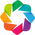

In [16]:
import holoviews as hv, colorcet as cc
import datashader as ds
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

In [1]:
'''
x,y = ds.utils.lnglat_to_meters(final_preprocessing.dLon, final_preprocessing.dLat)
final_preprocessing['dLon'] = x
final_preprocessing['dLat'] = y

해당 코드는 경도 위도 -> 윕머케이터 좌표계 변환 코드임
따라서, 데이터 프레임 변동이 없다면 처음에만 실행, 이후 실행 시 주석 처리 필수
'''

"\nx,y = ds.utils.lnglat_to_meters(final_preprocessing.dLon, final_preprocessing.dLat)\nfinal_preprocessing['dLon'] = x\nfinal_preprocessing['dLat'] = y\n\n해당 코드는 경도 위도 -> 윕머케이터 좌표계 변환 코드임\n따라서, 데이터 프레임 변동이 없다면 처음에만 실행, 이후 실행 시 주석 처리 필수\n"

In [24]:
# 최종 전처리 파일 Datashader visualization
x,y = ds.utils.lnglat_to_meters(final_preprocessing.dLon, final_preprocessing.dLat)
final_preprocessing['dLon'] = x
final_preprocessing['dLat'] = y

map_tiles = hv.element.tiles.EsriImagery().opts(alpha=0.5, width=600, height=600)

points = hv.Points(final_preprocessing, ['dLon', 'dLat'])

ship_traffic = datashade(points, cmap= 'magma', width=600, height=600, x_sampling=1, y_sampling=1)
datashade_visualization = map_tiles * ship_traffic
hv.save(datashade_visualization, 'final_preprocessing_datashade_.html')

In [25]:
# 전처리 이전 1600만 row 파일 Datashader visualization
x_,y_ = ds.utils.lnglat_to_meters(total.dLon, total.dLat)
total['dLon'] = x_
total['dLat'] = y_

map_tiles_ = hv.element.tiles.EsriImagery().opts(alpha=0.5, width=600, height=600)

points_ = hv.Points(total, ['dLon', 'dLat'])

ship_traffic_ = datashade(points_, cmap= 'magma', width=600, height=600, x_sampling=1, y_sampling=1)
datashade_visualization_ = map_tiles_ * ship_traffic_
hv.save(datashade_visualization_, 'total_datashade.html')

# 전처리 걸린 시간

In [12]:
import timeit

start = timeit.default_timer()
upper_2 = upper_2_dataframe(dict_)
a1 = timeit.default_timer()
add_dist = add_distance_df(upper_2)
a2 = timeit.default_timer()
dist_upper_10 = dist_upper_10_df(add_dist)
a3 = timeit.default_timer()
reset_time = reset_index_time_series(dist_upper_10)
a4 = timeit.default_timer()
add_cog = add_cog_interval(reset_time)
a5 = timeit.default_timer()
straigt_line = similar_straight_cog(add_cog)
end = timeit.default_timer()

print(f'전처리 전과정 수행 시간 : {end-start} sec')

print('--------------------------')
print(f'upper_2_dataframe 함수 실행 시간 : {a1 - start} sec')
print(f'add_distance_df 함수 실행 시간 : {a2 - a1} sec')
print(f'dist_upper_10_df 함수 실행 시간 : {a3 - a2} sec')
print(f'reset_time_series 함수 실행 시간 : {a4 - a3} sec')
print(f'add_cog_interval 함수 실행 시간 : {a5 - a4} sec')
print(f'similar_straight_cog 함수 실행 시간 : {end - a5} sec')

/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] = np.mean(dist)
/tmp/ipykernel_770786/343793087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'][1:] = dist
/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] =

/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] = np.mean(dist)
/tmp/ipykernel_770786/343793087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'][1:] = dist
/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] =

/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] = np.mean(dist)
/tmp/ipykernel_770786/343793087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'][1:] = dist
/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] =

/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] = np.mean(dist)
/tmp/ipykernel_770786/343793087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'][1:] = dist
/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] =

/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] = np.mean(dist)
/tmp/ipykernel_770786/343793087.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'][1:] = dist
/tmp/ipykernel_770786/343793087.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]['dist'] =

전처리 전과정 수행 시간 : 17.627289411844686 sec
--------------------------
upper_2_dataframe 함수 실행 시간 : 0.10475965798832476 sec
add_distance_df 함수 실행 시간 : 0.8865356529131532 sec
dist_upper_10_df 함수 실행 시간 : 0.10307586914859712 sec
reset_time_series 함수 실행 시간 : 4.104756576940417 sec
add_cog_interval 함수 실행 시간 : 0.12983293901197612 sec
similar_straight_cog 함수 실행 시간 : 12.298328715842217 sec


In [15]:
straigt_line[0][straigt_line[0].duplicated()]

,szMsgSendDT,SHIP_CODE,dSOG,dCOG,dLat,dLon,dist,dCOG_diff


# ---------------------------------------------------------------------------

# COG 기준 값 설정 (EDA)

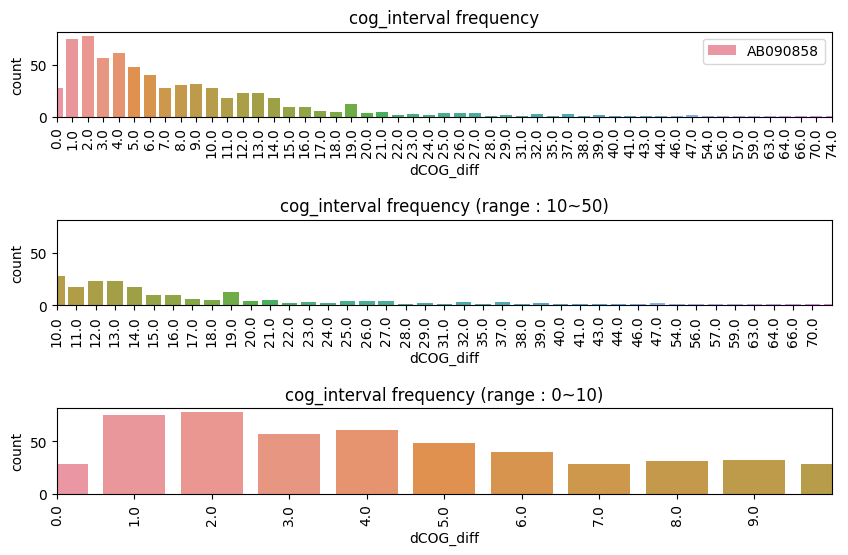

In [70]:
# cog_interval의 전처리 기준 값을 정하기 위해 cog_interval 의 분포를 알아보기 위한 코드
plt.figure(figsize = (10,6))

plt.subplot(3,1,1)
sns.countplot(x = 'dCOG_diff', data = add_cog)
plt.xlim([0,50])
plt.xticks(rotation = 90)
plt.plot()
plt.title('cog_interval frequency')
plt.legend(cog_interval.SHIP_CODE)


plt.subplot(3,1,2)
sns.countplot(x = 'dCOG_diff', data = add_cog)
plt.xlim([10,50])
plt.xticks(np.arange(10,50),rotation = 90)
plt.plot()
plt.title('cog_interval frequency (range : 10~50)')

plt.subplot(3,1,3)
sns.countplot(x = 'dCOG_diff', data = add_cog)
plt.xlim([0,10])
plt.xticks(np.arange(0,10),rotation = 90)
plt.plot()
plt.title('cog_interval frequency (range : 0~10)')

plt.subplots_adjust(hspace = 1.2)

plt.show()